---
title: Fig. 2 - Convergent evolution example
author: Benjamin Doran
date: today
---

In [ ]:
#| code-fold: true
#| code-summary: Julia Setup
using DrWatson
@quickactivate projectdir()

using SpectralInference # custom package from $projectdir/src
using NewickTree
using Gotree_jll, Goalign_jll
using StatsBase, NeighborJoining
using Distances, Clustering
using DataFrames, CSV
using Muon
using Symbolics
using StatsPlots
theme(:default, grid=false, label=false, tickdir=:out)
using LinearAlgebra
using LaTeXStrings
include(srcdir("helpers.jl"))
heatmapcols = [:purple, :black, :yellow];
generationcols = ["#B3D2FC" "#2B689E" "#338591"];

# Main - Example with convergent evolution

Spectral decomposition's like SVD and PCA are based on co-variation, therefore they incorporate information about contextual dependence between features and taxa.
This means that Spectral Inference can infer the correct ancestral tree even in cases of convergent evolution. Below we created an alignment of 18 taxa described by 9 features, where there are multiple evolutionary paths to get to each feature, i.e., each feature is only a good genomic feature that matches a true ancestral divergence in the context of other features.

Spectral Inference is able to perfectly recapitulate this ancestral tree, where standard phylogenetic tools fail.

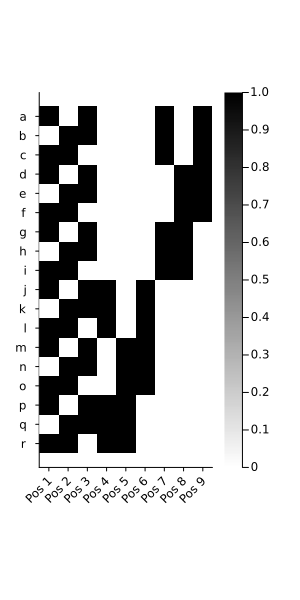

In [ ]:
M = Float64.([
    1 0 1 0 0 0 1 0 1;
    0 1 1 0 0 0 1 0 1;
    1 1 0 0 0 0 1 0 1;
    1 0 1 0 0 0 0 1 1;
    0 1 1 0 0 0 0 1 1;
    1 1 0 0 0 0 0 1 1;
    1 0 1 0 0 0 1 1 0;
    0 1 1 0 0 0 1 1 0;
    1 1 0 0 0 0 1 1 0;
    1 0 1 1 0 1 0 0 0;
    0 1 1 1 0 1 0 0 0;
    1 1 0 1 0 1 0 0 0;
    1 0 1 0 1 1 0 0 0;
    0 1 1 0 1 1 0 0 0;
    1 1 0 0 1 1 0 0 0;
    1 0 1 1 1 0 0 0 0;
    0 1 1 1 1 0 0 0 0;
    1 1 0 1 1 0 0 0 0;
]);
heatmap(M, 
    c=[:white, :black], 
    ratio=1, 
    xticks=(1:9, ["Pos $i" for i in 1:9]),
    xrotation=45,
    yticks=(1:18, 'a':'r'),
    yflip=true,
    size=(300, 600),
    margin=5Plots.mm,
)

In [ ]:
usv = svd(M);

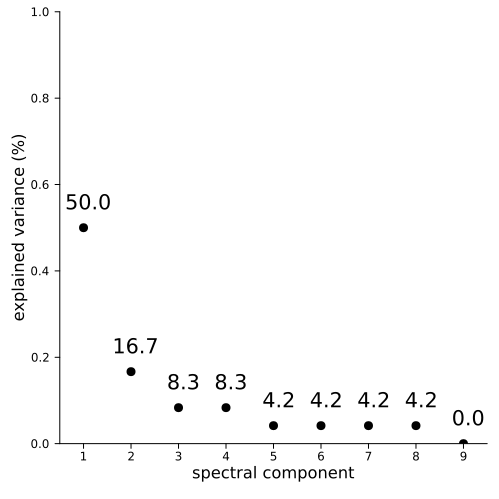

In [ ]:
plot(
    ylabel="explained variance (%)", 
    xlabel="spectral component", 
    legend=:none, 
    ylims=(0,1), xlims=(.5,9.5), 
    size=(500,500)
)
scatter!((usv.S.^2)/sum(usv.S.^2), 
    xticks=1:14, c=:black, markersize=5,
)
annotate!((1:length(usv.S)) .+ .1 , (usv.S.^2)/sum(usv.S.^2).+.06, round.((usv.S.^2)/sum(usv.S.^2)*100, digits=1))

### Phylogenetic inference with FastME, PhyML, and SPI

In the tree plots below only branches with an orange dot are statistically supported.

In [ ]:
toyMSA_18x9_dir = datadir("sims", "toyMSA_18x9") |> mkpath
# write out alignment
writephylip(
    joinpath(toyMSA_18x9_dir, "MSA.phylip"),
    join.(eachrow((replace(M, 0.0 => 'A', 1.0 => 'T')))),
    collect('a':'r')
)

In [ ]:
# FastME
run(`julia $(projectdir("scripts", "runners", "runFastME.jl")) 
    -i $(datadir("sims", "toyMSA_18x9", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_18x9", "FastME"))
    -m JC69
`)
# PhyML
run(`julia $(projectdir("scripts", "runners", "runPhyML.jl")) 
    -i $(datadir("sims", "toyMSA_18x9", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_18x9", "PhyML"))
    -m JC69
`)
# SpectralInference
run(`julia $(projectdir("scripts", "runners", "runSPI.jl")) 
    -i $(datadir("sims", "toyMSA_18x9", "MSA.phylip"))
    -o $(projectdir("_research", "toyMSA_18x9", "SPI"))
    -m JC69
`);
pdir_toyMSA_18x9 = plotsdir("toyMSA_18x9") |> mkpath

  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting FastME on MSA


[ Info: using Booster to compute support values


[ Info: stopping run


 ──────────────────────────────────────────────────────────────────────
                              Time                    Allocations      
                     ───────────────────────   ────────────────────────
  Tot / % measured:       586ms /  91.3%           51.6MiB /  89.7%    

 Section     ncalls     time    %tot     avg     alloc    %tot      avg
 ──────────────────────────────────────────────────────────────────────
 total            1    535ms  100.0%   535ms   46.3MiB  100.0%  46.3MiB
   booster        1    220ms   41.1%   220ms   1.16MiB    2.5%  1.16MiB
   FastME         1    181ms   33.9%   181ms   3.29MiB    7.1%  3.29MiB
 ──────────────────────────────────────────────────────────────────────
┌ Info: timing
│   show(time) = nothing
└   println("") = nothing


  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting PhyML on MSA


[ Info: stopping run
 ────────────────────────────────────────────────────────────────────
                            Time                    Allocations      
                   ───────────────────────   ────────────────────────
 Tot / % measured:      375ms /  87.4%           50.1MiB /  89.4%    

 Section   ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────
 total          1    328ms  100.0%   328ms   44.8MiB  100.0%  44.8MiB
   PhyML        1    194ms   59.2%   194ms   2.97MiB    6.6%  2.97MiB
 ────────────────────────────────────────────────────────────────────
┌ Info: timing
│   show(time) = nothing
└   println("") = nothing


  Activating

 project at `~/projects/Doran_etal_2023`


[ Info: Starting SPI inference
[ Info: Setting up workspace
[ Info: Running SPI


[ Info: Writing out SPI Tree
[ Info: Starting Bootstrap with 100


[ Info: Writing out Bootstrap trees
[ Info: using Booster to compute support values


[ Info: Finishing run
 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            1.68s /  95.9%            294MiB /  98.0%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 total                      1    1.61s  100.0%   1.61s    289MiB  100.0%   289MiB
   running SPI              1    930ms   57.8%   930ms    167MiB   58.0%   167MiB
   running bootstra...      1    183ms   11.4%   183ms   67.4MiB   23.3%  67.4MiB
 ────────────────────────────────────────────────────────────────────────────────


┌ Info: 
│ timing
│   show(time) = nothing
└   println("") = nothing


"/Users/bend/projects/Doran_etal_2023/plots/toyMSA_18x9"

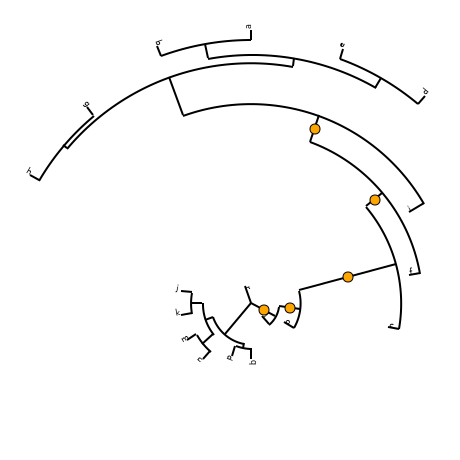

In [ ]:
method = "FastME"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_18x9", method, "MSA-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_18x9, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_18x9, method * ".svg"))

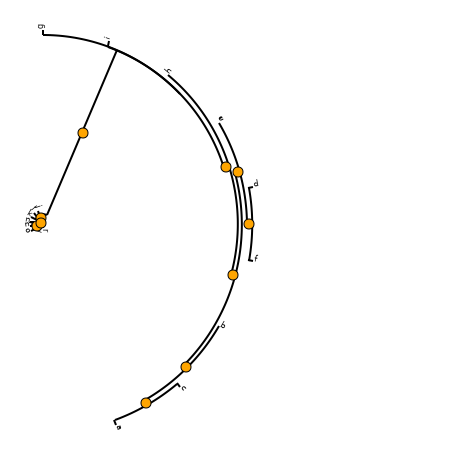

In [ ]:
method = "PhyML"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_18x9", method, "MSA.phylip-supporttree.txt"),
    stdout=joinpath(pdir_toyMSA_18x9, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_18x9, method * ".svg"))

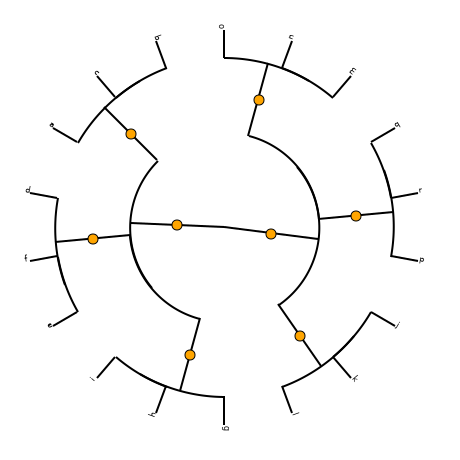

In [ ]:
method = "SPI"
run(pipeline(`$(gotree()) draw svg -c -w 400 -H 400 --support-cutoff .5 --with-branch-support`,
    stdin=projectdir("_research", "toyMSA_18x9", method, "MSA-supporttree.nw"),
    stdout=joinpath(pdir_toyMSA_18x9, method * ".svg")
))
show_svg(joinpath(pdir_toyMSA_18x9, method * ".svg"))

### How is information encoded about convergent processes?

We show that subsets of principal components, hold information that project taxa to different positions based on the ancestral path they took to obtain a particular genomic feature.

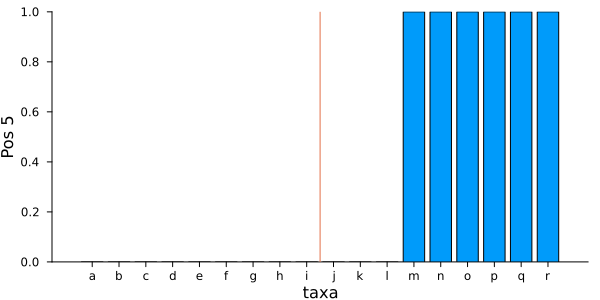

In [ ]:
#| fig-cap: taxa a-i and j-r split at the first generation. using position 5 as a gene marker would place j-l with a-i as they both lost this feature through convergent processes.
bar(M[:, 5],
    xticks=(1:18, 'a':'r'),
    xlabel="taxa",
    ylabel="Pos 5",
    size=(600, 300),
)
vline!([9.5])

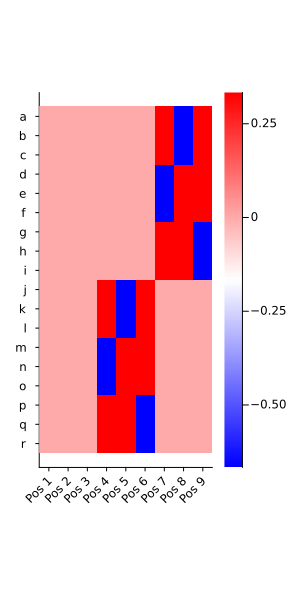

In [ ]:
#| fig-cap: recreated alignment matrix from components 5-8. These components shows the mutations incuded in generation F2 in blue
Mspectrallyfiltered = usv.U[:, 5:8] * Diagonal(usv.S[5:8]) * usv.Vt[5:8, :]
heatmap(Mspectrallyfiltered, 
    c=:bwr, 
    ratio=1, 
    xticks=(1:9, ["Pos $i" for i in 1:9]),
    xrotation=45,
    yticks=(1:18, 'a':'r'),
    yflip=true,
    size=(300, 600),
    margin=5Plots.mm,
)

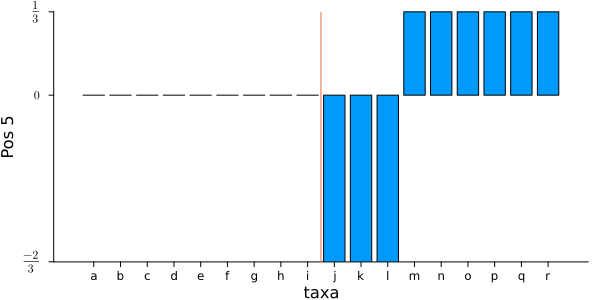

In [ ]:
#| fig-cap: recreating the alignment using components 5-8, transforms position 5 in such a way that taxa j-l are distict because they lost this feature in a different context as to taxa a-i
bar(Mspectrallyfiltered[:, 5],
    xticks=(1:18, 'a':'r'),
    xlabel="taxa",
    ylabel="Pos 5",
    size=(600, 300),
    ylims=(-.6667, .33334),
    widen=true,
    yticks=([-0.666, 0.0, .3333], [L"\frac{-2}{3}", L"0", L"\frac{1}{3}"])
)
vline!([9.5])

We show in this case as well that information regarding more recent generational differences correlate to deeper principal components

In [ ]:
spectralcorrs = map([i:(i+2) for i in 1:(size(M,2)-2)]) do window
    spectralcorrelations(usv.U, window)
end;

F1mask = kron([1 0; 0 1], ones(3,3), ones(3,3))
F2mask = kron(Diagonal(ones(6)), ones(3,3));
uppertriangle = triu(trues(18, 18), 1);

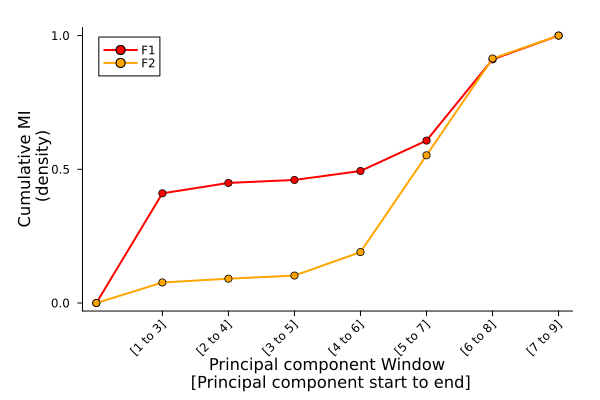

In [ ]:
f1mi = map(spectralcorrs) do spcorr 
    empiricalMI(spcorr[uppertriangle], (F1mask .== 1)[uppertriangle]) # edges=-1:0.001:1
end
f2mi = map(spectralcorrs) do spcorr 
    empiricalMI(spcorr[uppertriangle], (F2mask .== 1)[uppertriangle]) # edges=-1:0.001:1
end

plot(
    ylabel="Cumulative MI\n (density)",
    xlabel="Principal component Window\n [Principal component start to end]",
    yticks=[0.0, .5, 1.0],
    xticks=(2:8, ["[$i to $(i+2)]" for i in 1:7]),
    xrotation=45,
    margin=5Plots.mm,
)
plot!(scaledcumsum(vcat(0, f1mi)), c=:red, marker=true, label="F1", lw=2,)
plot!(scaledcumsum(vcat(0, f2mi)), c=:orange, marker=true, label="F2", lw=2,)

# Fig. S5 - Timing benchmark

Spectral Inference is fast, it is based on PCA. So it has the potential to scale quite large. Thousands of taxa on a laptop, larger using clusters and distributed computing.

Here we just show that Spectral Inference (SPI) does not grow exponentially with the number of taxa.

In [ ]:
## create UniProt subsets
uniprot = readh5ad(datadir("exp_raw", "UP7047", "2020_02_UP7047.h5ad"))
rowmeta = uniprot.obs;

outdir = datadir("exp_pro", "UPsubsetMSAs") |> mkpath
pdir = plotsdir("timeing_benchmark") |> mkpath

"/Users/bend/projects/Doran_etal_2023/plots/timeing_benchmark"

### Subset to different number of taxa

* 25 taxa at Genus level (Ruminococcus)
* 50 taxa at Family level (Rhodospirillaceae)
* 103 taxa at Order level (Oceanospirillales)
* 211 taxa at Class level (Bacteroidia)

In [ ]:
#| code-fold: true
#| code-summary: write out each subset as pseudo-alignment

## Genus
genus_choice_df = combine(nrow, groupby(rowmeta, :Genus)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->24 .< x .< 27, df)
display(genus_choice_df)

mask = findall(==("Ruminococcus"), rowmeta.Genus);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=25_level=Genus_group=Ruminococcus_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

## Family
family_choice_df = combine(nrow, groupby(rowmeta, :Family)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->48 .< x .< 52, df)
display(family_choice_df)

mask = findall(==("Rhodospirillaceae"), rowmeta.Family);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=50_level=Family_group=Rhodospirillaceae_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

## Order
order_choice_df = combine(nrow, groupby(rowmeta, :Order)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->95 .< x .< 105, df)
display(order_choice_df)

mask = findall(==("Oceanospirillales"), rowmeta.Order);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=103_level=Order_group=Oceanospirillales_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

## Class
class_choice_df = combine(nrow, groupby(rowmeta, :Class)) |>
    df->sort(df, :nrow, rev=true) |>
    df->filter(:nrow=>x->190 .< x .< 215, df)
display(class_choice_df)

mask = findall(==("Bacteroidia"), rowmeta.Class);
subsetMSA = Char.(replace(uniprot.X[mask, :] .> 0.0, true=>'T', false=>'A'))
open(joinpath(outdir, "UPsubset_taxa=211_level=Class_group=Bacteroidia_alphabet=AT.phy"), "w") do io
    println(io, size(subsetMSA, 1), " ", size(subsetMSA, 2))
    for (id, row) in zip(rowmeta.proteomeID[mask], eachslice(subsetMSA, dims=1))
        println(io, id, "    ", join(row))
    end
end

Row,Genus,nrow
,String,Int64
1,Helicobacter,26
2,Ruminococcus,25


Row,Family,nrow
,String,Int64
1,Alteromonadaceae,51
2,Rhodospirillaceae,50


Row,Order,nrow
,String,Int64
1,Oceanospirillales,103
2,Pseudomonadales,97


Row,Class,nrow
,String,Int64
1,Bacteroidia,211


In [ ]:
## submit job to cluster to run all phylogenetic inference tasks in parallel
# run(`sbatch $(projectdir("scripts", "slurm-run-PI-on-UPsubsets.sbatch"))`)

In [ ]:
time_per_run_df = CSV.read(projectdir("_research", "UPsubsetMSAs", "timeperjob.log"), DataFrame, delim="\t");

In [ ]:
pltdf = sort(time_per_run_df, :Seq) |>
    df->filter(:Exitval=> ==(0), df) |>
    df->transform(df, :Command=>(x->replace.(x, r"(.*)((?<=\/t)[0-9]*)(.*)"=>s"\2"))=> :Ntaxa ) |>
    df->transform(df, :Command=>(x->replace.(x, r"(.*)((?<=runners\/run)[a-zA-Z]*)(.*)"=>s"\2"))=> :method);

pltdf = pltdf[:, [:method, :Ntaxa, :JobRuntime]];
pltdf.Ntaxa = parse.(Int, pltdf.Ntaxa);
pltdf = sort(pltdf, [:method, :Ntaxa]);
pltdf = subset(pltdf, :method => ByRow(!=("FastME")))
pltdf

Row,method,Ntaxa,JobRuntime
,String,Int64,Float64
1,FastTree,25,883.487
2,FastTree,50,2011.95
3,FastTree,103,4044.1
4,FastTree,211,6906.7
5,MrBayes,25,728.282
6,MrBayes,50,1730.24
7,MrBayes,103,7628.71
8,MrBayes,211,9608.94
9,PhyML,25,439.039


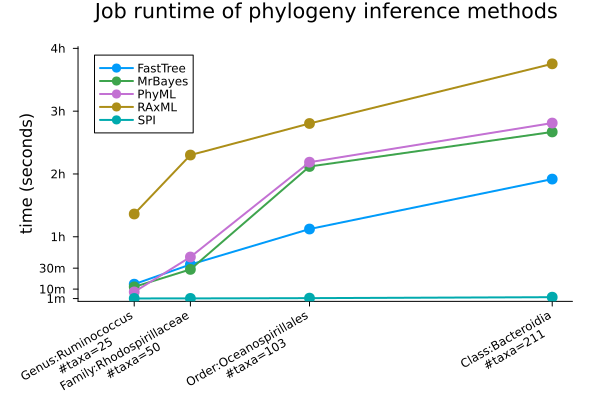

In [ ]:
plot(title="Job runtime of phylogeny inference methods",
    ylabel="time (seconds)",
    yticks=([60, 600, 1800, 3600, 7200, 10800, 14400], ["1m", "10m", "30m", "1h", "2h", "3h", "4h"]),
    xticks=([25, 50, 103, 211], [
        "Genus:Ruminococcus\n #taxa=25",
        "Family:Rhodospirillaceae\n #taxa=50",
        "Order:Oceanospirillales\n #taxa=103",
        "Class:Bacteroidia\n #taxa=211",
         ]),
    xrotation=30,
    margin=5Plots.Measures.mm,
    ylims=(-100, 14500),
    xlims=(0, 220),
    legend=:topleft,
)
@df pltdf plot!(:Ntaxa, :JobRuntime, group=:method, markers=true,
    linewidth=2,
    markersize=6,
    markerstrokewidth=0,
    c=permutedims(vcat([1],3:7)))

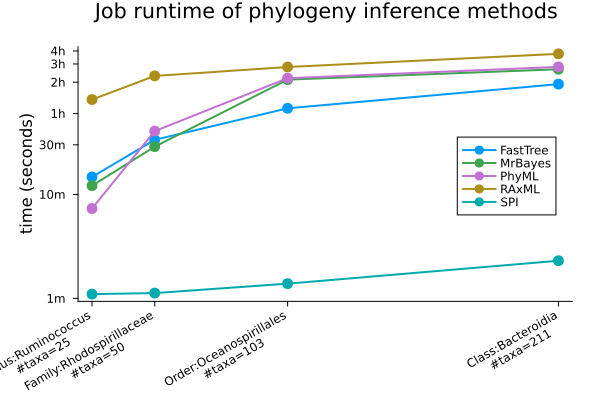

In [ ]:
plot(title="Job runtime of phylogeny inference methods",
    ylabel="time (seconds)",
    yticks=([60, 600, 1800, 3600, 7200, 10800, 14400], ["1m", "10m", "30m", "1h", "2h", "3h", "4h"]),
    xticks=([25, 50, 103, 211], [
        "Genus:Ruminococcus\n #taxa=25",
        "Family:Rhodospirillaceae\n #taxa=50",
        "Order:Oceanospirillales\n #taxa=103",
        "Class:Bacteroidia\n #taxa=211",
         ]),
    xrotation=30,
    margin=5Plots.Measures.mm,
    # ylims=(-100, 14500),
    # xlims=(0, 220),
    legend=:right,
)
@df pltdf plot!(:Ntaxa, :JobRuntime, group=:method, markers=true,
    linewidth=2,
    markersize=6,
    markerstrokewidth=0,
    c=permutedims(vcat([1],3:7)),
    yscale=:log10,
)

In [ ]:
savefig(joinpath(pdir, "timeing_benchmark_logscale.pdf"))

"/Users/bend/projects/Doran_etal_2023/plots/timeing_benchmark/timeing_benchmark_logscale.pdf"